In [40]:
import os
import re
import logging

import numpy as np
import cv2 as cv
import yaml
import itertools

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import h5py


In [41]:
import sys
sys.path.append("../offline/train_mb_error_detector/")
from tools import get_error_GT, get_error_map

In [3]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

model_path = '/home/ssawmya-local/FM_work/Notebooks_and_files/checkpoint_50ns/resnet18.pth'
weights = torch.load(model_path)
model.load_state_dict(weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [5]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"

In [6]:
from tqdm import tqdm
dwt = 50

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
def get_membranes( img, get_probs=False):
        # print(img.shape)
        # img = self.preprocess(img)
        # print("After preprocessing", img.shape)
        # img = img.transpose(2, 0, 1)
        img = img[:, :-(img.shape[1] % 32), :]
        img = torch.as_tensor(img.copy()).float().contiguous()
        img = img.unsqueeze(0)
        img = img.to(device=device, dtype=torch.float32)
        
        with torch.no_grad():
            # print("Before passing", img.shape)
            output = model(img).cpu()
            # binarize the output based on the threshold of 0.5
            if (output >= 0).all() and (output <= 1).all():
                mask = output > 0.5
            else:
                
                output = torch.sigmoid(output)
                mask = output > 0.5

        mask = mask.squeeze().numpy()[1]
        mask = mask.astype(np.uint8) * 255
        
        # print("Done outputs")
        if not get_probs:
            return mask
        else:
            output = output.squeeze().numpy()[1]
            return mask, output

In [43]:
with h5py.File(hdf5_path, 'r') as h5:
    regs=h5.attrs["regs"]
    data_to_save = {}
    out_regs = []
    print(len(regs))
    masks = []
    ims = []
    for reg in tqdm(regs, desc="generating membrane predictions..."):
        im,mask=h5[reg+"/"+str(dwt)+"/im"],h5[reg+"/"+str(dwt)+"/mask"]
        im = np.array(im)
        im = im[np.newaxis, ...] # make 3d
        print(im.shape)

        mask = np.squeeze(mask)
        mask = mask[:-(mask.shape[0] % 32),:]
        smask = (mask).astype(np.uint8)
        print(np.unique(smask))

        _, mask_prob = get_membranes(img = im, get_probs=True)
        
        
        
        mb_probs = (mask_prob*255).astype(np.uint8)
        # print(mask.shape, mb_probs.shape)
        vi,vi_split,vi_merge,splitters,mergers,fm_wshed,sm_wshed = get_error_map(mb_probs, smask, only_vi=True)
        break
        # add the channel dimension
        # im = np.expand_dims(im, axis=2)
        # print(im.shape)

18


generating membrane predictions...:   0%|          | 0/18 [00:00<?, ?it/s]

(1, 1640, 1920)
[  0 255]


generating membrane predictions...:   0%|          | 0/18 [00:08<?, ?it/s]


In [50]:
with h5py.File(hdf5_path, 'r') as h5:
    regs=h5.attrs["regs"]

    for reg in tqdm(regs, desc="generating membrane predictions..."):
        hwt_im = h5[reg+"/1200/im"]
        break

generating membrane predictions...:   0%|          | 0/18 [00:00<?, ?it/s]


In [44]:
print(vi_split)
print(vi_merge)

0.04767029709837374
0.18036080714087677


(-0.5, 1919.5, 1639.5, -0.5)

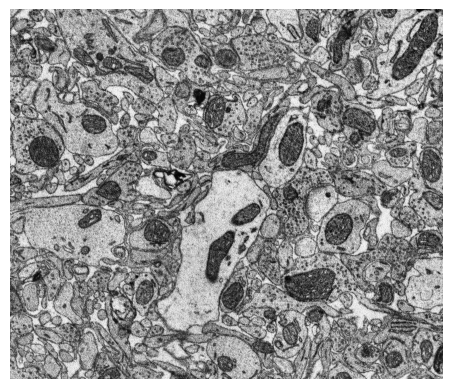

In [46]:
import matplotlib.pyplot as plt
plt.imshow(im[0], cmap = 'gray')
plt.axis('off')

(-0.5, 1919.5, 1631.5, -0.5)

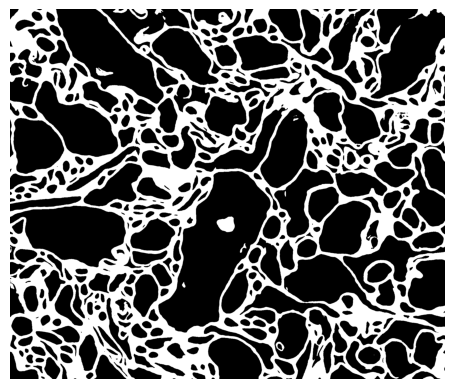

In [47]:

plt.imshow(smask, cmap = 'gray')
plt.axis('off')

In [36]:
vi_thres = 1e-5
i_splits=splitters[splitters[:,0]>vi_thres,1].astype(np.uint32)
print(i_splits)

[ 17   4 284  93 425   8 101 300 400 395  89 132 342  15 471  75 308 270
 185 152 208  58  73 428 304 446 355]


In [ ]:

def get_prediction(im, model):
    # applies network to 2d numpy image
    im = im[np.newaxis, ...] # make 3d
    im = torch.as_tensor(im.copy()).float().contiguous()
    im = im.unsqueeze(0)
    im = im.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = model(im).cpu()
        # binarize the output based on the threshold of 0.5
        if (output >= 0).all() and (output <= 1).all():
            mask = output > 0.5
        else:
            output = torch.sigmoid(output)
            mask = output > 0.5

    mask = mask.squeeze().numpy()[1]
    mask = mask.astype(np.uint8) * 255
    probs = output.squeeze().numpy()[1]

    return mask, probs
    

